In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import itertools
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from sklearn.linear_model import LinearRegression

### Steps followed - 

#### 1. Creating training and test datatsets for GO-FOOD service
#### 2. Create cartesian product for all dates combination
#### 3. Aggregate GMV for every booking date
#### 4. Create the time-period columns - day, month, day of week & weekend flag
#### 5. Encode time-period columns - day, month, day of week
#### 6. Scale and standarize columns
#### 7. Train Multiple Linear Regression model
#### 8. Create the time-period columns - day, month, day of week & weekend flag
#### 9. Follow steps  3-6 for test data
#### 10. Predict GMV for GO-FOOD for 29th, 20th & 31st Jan
#### 11. Inverse scale predicted GMV values and calculate MAPE
#### 12. Cross validate using k-fold




In [2]:
# Data preprocessing

df = pd.read_csv("assignment_data.csv", parse_dates=["booking_time"])
df['actual_gmv'] = df['actual_gmv'].fillna(0)
df['booking_dt'] = pd.to_datetime(df['booking_time']).dt.date
df

,Unnamed: 0,order_no,customer_id,driver_id,service_type,booking_time,actual_gmv,booking_dt
0,0,GK-11-377000658,141,541541952.0,GO-SEND-WEB,2021-01-09 00:04:35.600785+00:00,0.0,2021-01-09
1,1,GK-11-377000660,141,541860727.0,GO-SEND-WEB,2021-01-09 00:04:36.042753+00:00,0.0,2021-01-09
2,2,GK-11-377001095,141,700871170.0,GO-SEND-WEB,2021-01-09 00:08:43.994586+00:00,0.0,2021-01-09
3,3,GK-11-377001557,141,541614894.0,GO-SEND-WEB,2021-01-09 00:12:49.208030+00:00,0.0,2021-01-09
4,4,GK-11-377002123,141,541213672.0,GO-SEND-WEB,2021-01-09 00:17:34.530810+00:00,0.0,2021-01-09
...,...,...,...,...,...,...,...,...
5820458,5820458,GK-11-381986793,574100402,700775914.0,GO-SEND,2021-01-24 01:52:18.889339+00:00,0.0,2021-01-24
5820459,5820459,GPL-d84c4bfd3e8973,561417994,0.0,GO-PULSA,2020-12-31 18:11:51.405000+00:00,15356.0,2020-12-31
5820460,5820460,GPL-d7f089c4878629,599868511,0.0,GO-PULSA,2021-01-26 00:17:47.342000+00:00,6720.0,2021-01-26
5820461,5820461,GK-11-377593536,585131176,700788008.0,GO-SEND,2021-01-11 01:10:28.614482+00:00,0.0,2021-01-11


In [5]:
del df['Unnamed: 0']
del df['order_no']
del df['customer_id']
del df['driver_id']

In [6]:
df

,service_type,booking_time,actual_gmv,booking_dt
0,GO-SEND-WEB,2021-01-09 00:04:35.600785+00:00,0.0,2021-01-09
1,GO-SEND-WEB,2021-01-09 00:04:36.042753+00:00,0.0,2021-01-09
2,GO-SEND-WEB,2021-01-09 00:08:43.994586+00:00,0.0,2021-01-09
3,GO-SEND-WEB,2021-01-09 00:12:49.208030+00:00,0.0,2021-01-09
4,GO-SEND-WEB,2021-01-09 00:17:34.530810+00:00,0.0,2021-01-09
...,...,...,...,...
5820458,GO-SEND,2021-01-24 01:52:18.889339+00:00,0.0,2021-01-24
5820459,GO-PULSA,2020-12-31 18:11:51.405000+00:00,15356.0,2020-12-31
5820460,GO-PULSA,2021-01-26 00:17:47.342000+00:00,6720.0,2021-01-26
5820461,GO-SEND,2021-01-11 01:10:28.614482+00:00,0.0,2021-01-11


In [8]:
# Create training dataset 

df_train = df[df.booking_dt < pd.to_datetime("2021-01-29").date()]
df_train.shape

(5250534, 4)

In [9]:
# Create test dataset 

df_test = df[df.booking_dt > pd.to_datetime("2021-01-28").date()]
df_test.shape

(569929, 4)

In [10]:
# Create first model for GO-FOOD service and hence subset only relevant data

dfs_tr_food = df_train[df_train.service_type == 'GO-FOOD']
dfs_tr_food.shape

(362410, 4)

In [11]:
# Generate a dataframe with every date between 31-dec & 28-Jan-21. This is needed to ensure the complete combinations (cartesian product) of date and service types are present

dates = pd.date_range('12-31-2020', '01-28-2021')
service_type = ['GO-FOOD']

sample_dt = pd.DataFrame(list(itertools.product(dates, service_type)))

sample_dt['actual_gmv'] = 0

sample_dt['booking_time'] = pd.to_datetime(sample_dt[0],format='%Y%m%d hh:mi:ss')

sample_dt1 = sample_dt[['booking_time',1,'actual_gmv',0]]

sample_dt1.rename(columns={1:'service_type', 0:'booking_dt'}, inplace=True)

sample_dt1

,booking_time,service_type,actual_gmv,booking_dt
0,2020-12-31,GO-FOOD,0,2020-12-31
1,2021-01-01,GO-FOOD,0,2021-01-01
2,2021-01-02,GO-FOOD,0,2021-01-02
3,2021-01-03,GO-FOOD,0,2021-01-03
4,2021-01-04,GO-FOOD,0,2021-01-04
5,2021-01-05,GO-FOOD,0,2021-01-05
6,2021-01-06,GO-FOOD,0,2021-01-06
7,2021-01-07,GO-FOOD,0,2021-01-07
8,2021-01-08,GO-FOOD,0,2021-01-08
9,2021-01-09,GO-FOOD,0,2021-01-09


In [12]:
# concatenate with training set for GO-FOOD to get cartesian product list

dfs_tr_food_fi = pd.concat([dfs_tr_food, sample_dt1])

In [13]:
# create aggregated dataset by grouping per booking date

dfs_tr_food_fi['booking_dt'] = pd.to_datetime(dfs_tr_food_fi['booking_time'], utc=True).dt.date

dfs_tr_food_sum = dfs_tr_food_fi[['booking_dt','actual_gmv']]

dfs_tr_food_sum = dfs_tr_food_sum.groupby("booking_dt").agg({'actual_gmv' : 'sum'})

dfs_tr_food_sum


,actual_gmv
booking_dt,
2020-12-31,659530065.0
2021-01-01,720314630.0
2021-01-02,704274226.0
2021-01-03,725341470.0
2021-01-04,614189045.0
2021-01-05,616536248.0
2021-01-06,623529670.0
2021-01-07,614567814.0
2021-01-08,643132100.0


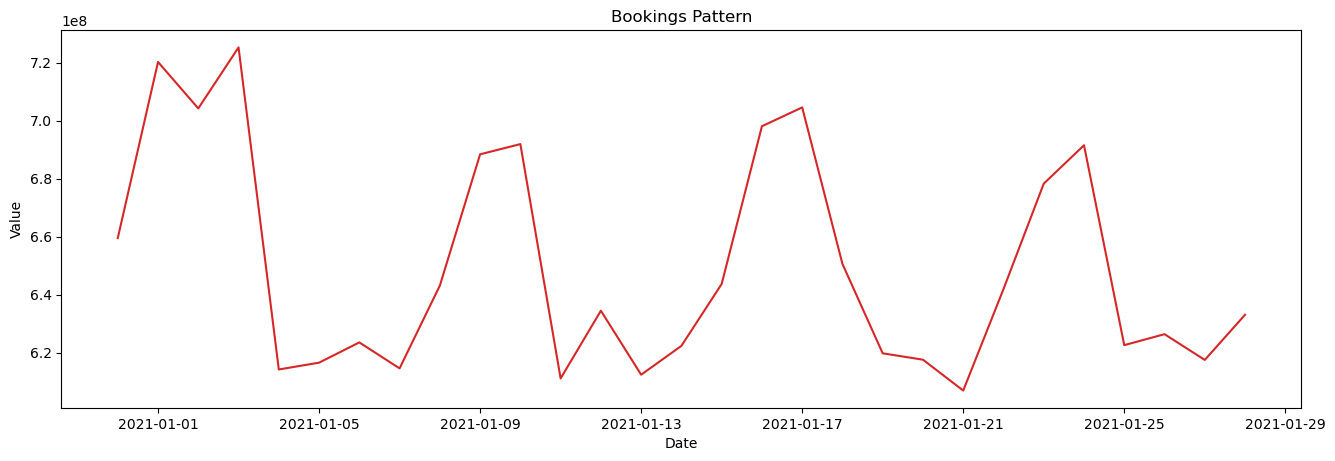

In [15]:
# plot bookings pattern

def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    

plot_df(dfs_tr_food_sum, x=dfs_tr_food_sum.index, y=dfs_tr_food_sum.actual_gmv, title='Bookings Pattern') 

In [16]:
dfs_tr_food_sum.reset_index(inplace=True)

dfs_tr_food_sum

,booking_dt,actual_gmv
0,2020-12-31,659530065.0
1,2021-01-01,720314630.0
2,2021-01-02,704274226.0
3,2021-01-03,725341470.0
4,2021-01-04,614189045.0
5,2021-01-05,616536248.0
6,2021-01-06,623529670.0
7,2021-01-07,614567814.0
8,2021-01-08,643132100.0
9,2021-01-09,688438252.0


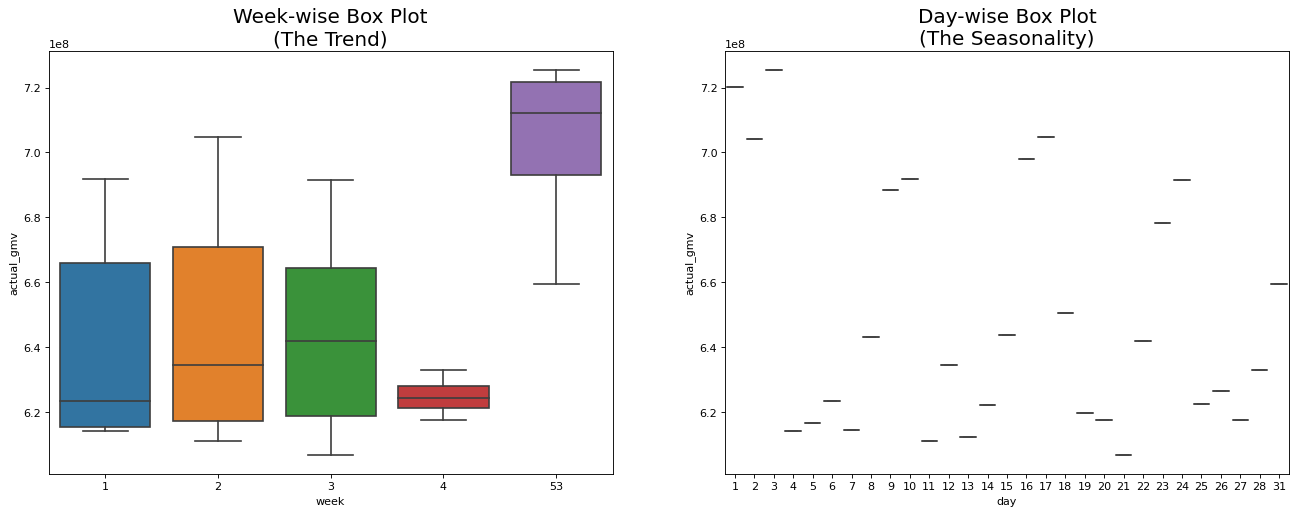

In [17]:
# Prepare data
dfs_tr_food_sum['week'] = pd.to_datetime(dfs_tr_food_sum['booking_dt']).dt.week
dfs_tr_food_sum['day'] = pd.to_datetime(dfs_tr_food_sum['booking_dt']).dt.day
weeks = dfs_tr_food_sum['week'].unique()

# Draw Plot
fig, axes = plt.subplots(1,2, figsize=(20,7), dpi= 80)
sns.boxplot(x='week', y='actual_gmv', data=dfs_tr_food_sum, ax=axes[0])
sns.boxplot(x='day', y='actual_gmv', data=dfs_tr_food_sum)

# Set Title
axes[0].set_title('Week-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Day-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [18]:
# calculate the predictor columns - day, month, day of week & weekend flag

dfs_tr_food_sum['day_of_week'] = pd.to_datetime(dfs_tr_food_sum['booking_dt']).dt.dayofweek 

dfs_tr_food_sum['day'] = pd.to_datetime(dfs_tr_food_sum['booking_dt']).dt.day 

dfs_tr_food_sum['month'] = pd.to_datetime(dfs_tr_food_sum['booking_dt']).dt.month

dfs_tr_food_sum['is_weekend_flag'] = ((pd.DatetimeIndex(dfs_tr_food_sum['booking_dt']).dayofweek) // 5 == 1).astype(int)

dfs_tr_food_sum


,booking_dt,actual_gmv,week,day,day_of_week,month,is_weekend_flag
0,2020-12-31,659530065.0,53,31,3,12,0
1,2021-01-01,720314630.0,53,1,4,1,0
2,2021-01-02,704274226.0,53,2,5,1,1
3,2021-01-03,725341470.0,53,3,6,1,1
4,2021-01-04,614189045.0,1,4,0,1,0
5,2021-01-05,616536248.0,1,5,1,1,0
6,2021-01-06,623529670.0,1,6,2,1,0
7,2021-01-07,614567814.0,1,7,3,1,0
8,2021-01-08,643132100.0,1,8,4,1,0
9,2021-01-09,688438252.0,1,9,5,1,1


#### Time-based features such as day of month & day of week have a cyclic nature. One-hot encoding day of month feature results in 31 dimensionality vector. Hence one-hot encoding is not used here to avoid curse of dimensionality.
#### Instead we compute sin & cos for these features and thus there are only 2 columns for each feature and also maintains their cyclical nature (sin & cos represent x & y-axis components for points on a unit circle). We have reduced month & day of month by 1 to match the scale of "day of week" which starts from 0.

In [19]:
dfs_tr_food_sum['dw_sin'] = np.sin(dfs_tr_food_sum.day_of_week*(2.*np.pi/7))
dfs_tr_food_sum['dw_cos'] = np.cos(dfs_tr_food_sum.day_of_week*(2.*np.pi/7))
dfs_tr_food_sum['mnth_sin'] = np.sin((dfs_tr_food_sum.month-1)*(2.*np.pi/12))
dfs_tr_food_sum['mnth_cos'] = np.cos((dfs_tr_food_sum.month-1)*(2.*np.pi/12))
dfs_tr_food_sum['dm_sin'] = np.sin((dfs_tr_food_sum.day-1)*(2.*np.pi/31))
dfs_tr_food_sum['dm_cos'] = np.cos((dfs_tr_food_sum.day-1)*(2.*np.pi/31))
dfs_tr_food_sum

,booking_dt,actual_gmv,week,day,day_of_week,month,is_weekend_flag,dw_sin,dw_cos,mnth_sin,mnth_cos,dm_sin,dm_cos
0,2020-12-31,659530065.0,53,31,3,12,0,0.433884,-0.900969,-0.5,0.866025,-0.201299,0.979530
1,2021-01-01,720314630.0,53,1,4,1,0,-0.433884,-0.900969,0.0,1.000000,0.000000,1.000000
2,2021-01-02,704274226.0,53,2,5,1,1,-0.974928,-0.222521,0.0,1.000000,0.201299,0.979530
3,2021-01-03,725341470.0,53,3,6,1,1,-0.781831,0.623490,0.0,1.000000,0.394356,0.918958
4,2021-01-04,614189045.0,1,4,0,1,0,0.000000,1.000000,0.0,1.000000,0.571268,0.820763
5,2021-01-05,616536248.0,1,5,1,1,0,0.781831,0.623490,0.0,1.000000,0.724793,0.688967
6,2021-01-06,623529670.0,1,6,2,1,0,0.974928,-0.222521,0.0,1.000000,0.848644,0.528964
7,2021-01-07,614567814.0,1,7,3,1,0,0.433884,-0.900969,0.0,1.000000,0.937752,0.347305
8,2021-01-08,643132100.0,1,8,4,1,0,-0.433884,-0.900969,0.0,1.000000,0.988468,0.151428
9,2021-01-09,688438252.0,1,9,5,1,1,-0.974928,-0.222521,0.0,1.000000,0.998717,-0.050649


In [22]:
# Select predictor columns

sb_tr_food = dfs_tr_food_sum[['mnth_sin','mnth_cos', 'dm_sin', 'dm_cos','dw_sin', 'dw_cos', 'is_weekend_flag' ]]
sb_tr_food

,mnth_sin,mnth_cos,dm_sin,dm_cos,dw_sin,dw_cos,is_weekend_flag
0,-0.5,0.866025,-0.201299,0.979530,0.433884,-0.900969,0
1,0.0,1.000000,0.000000,1.000000,-0.433884,-0.900969,0
2,0.0,1.000000,0.201299,0.979530,-0.974928,-0.222521,1
3,0.0,1.000000,0.394356,0.918958,-0.781831,0.623490,1
4,0.0,1.000000,0.571268,0.820763,0.000000,1.000000,0
5,0.0,1.000000,0.724793,0.688967,0.781831,0.623490,0
6,0.0,1.000000,0.848644,0.528964,0.974928,-0.222521,0
7,0.0,1.000000,0.937752,0.347305,0.433884,-0.900969,0
8,0.0,1.000000,0.988468,0.151428,-0.433884,-0.900969,0
9,0.0,1.000000,0.998717,-0.050649,-0.974928,-0.222521,1


In [24]:
# Scale & standardise actual_gmv to fit between (-1,1) scale. Standardising predictors is no longer needed 
# since all of them have already been reduced within (-1,1) scale 

columns_to_scale = ['actual_gmv']

scaler = StandardScaler() 

scaled_column = scaler.fit_transform(dfs_tr_food_sum[columns_to_scale])

scaled_column



array([[ 0.27201651],
       [ 1.91608227],
       [ 1.4822307 ],
       [ 2.05204533],
       [-0.95434117],
       [-0.89085538],
       [-0.70170135],
       [-0.94409644],
       [-0.17150616],
       [ 1.05390843],
       [ 1.14937858],
       [-1.03813922],
       [-0.40583379],
       [-1.00319135],
       [-0.73418792],
       [-0.15634061],
       [ 1.31601142],
       [ 1.49175761],
       [ 0.03101934],
       [-0.80352883],
       [-0.86299589],
       [-1.15117107],
       [-0.20407344],
       [ 0.78003336],
       [ 1.13856446],
       [-0.72729132],
       [-0.62483238],
       [-0.86524737],
       [-0.4437143 ]])

In [25]:
# join encoded & scaled data - 

processed_data = np.concatenate([scaled_column, sb_tr_food], axis=1)

processed_data

array([[ 0.27201651, -0.5       ,  0.8660254 , -0.20129852,  0.97952994,
         0.43388374, -0.90096887,  0.        ],
       [ 1.91608227,  0.        ,  1.        ,  0.        ,  1.        ,
        -0.43388374, -0.90096887,  0.        ],
       [ 1.4822307 ,  0.        ,  1.        ,  0.20129852,  0.97952994,
        -0.97492791, -0.22252093,  1.        ],
       [ 2.05204533,  0.        ,  1.        ,  0.39435586,  0.91895781,
        -0.78183148,  0.6234898 ,  1.        ],
       [-0.95434117,  0.        ,  1.        ,  0.57126822,  0.82076344,
         0.        ,  1.        ,  0.        ],
       [-0.89085538,  0.        ,  1.        ,  0.72479279,  0.68896692,
         0.78183148,  0.6234898 ,  0.        ],
       [-0.70170135,  0.        ,  1.        ,  0.84864426,  0.52896401,
         0.97492791, -0.22252093,  0.        ],
       [-0.94409644,  0.        ,  1.        ,  0.93775213,  0.34730525,
         0.43388374, -0.90096887,  0.        ],
       [-0.17150616,  0.        

In [26]:
## Training Multiple Linear Regression model

X_train, y_train = processed_data[:, 1:], processed_data[:, 0:1]

regressor_MultiLinear = LinearRegression()

regressor_MultiLinear.fit(X_train,y_train)


LinearRegression()

In [28]:
# Creating test dataset

dfs_tt_food = df_test[df_test.service_type == 'GO-FOOD']

dfs_tt_food

,service_type,booking_time,actual_gmv,booking_dt
3887949,GO-FOOD,2021-01-30 00:00:00.611887+00:00,50500.0,2021-01-30
3887950,GO-FOOD,2021-01-30 00:00:00.776695+00:00,98500.0,2021-01-30
3887951,GO-FOOD,2021-01-30 00:00:00.973800+00:00,49000.0,2021-01-30
3887952,GO-FOOD,2021-01-30 00:00:00.976722+00:00,35000.0,2021-01-30
3887953,GO-FOOD,2021-01-30 00:00:01.347932+00:00,20000.0,2021-01-30
...,...,...,...,...
5819638,GO-FOOD,2021-01-30 00:13:32.466727+00:00,75000.0,2021-01-30
5819738,GO-FOOD,2021-01-29 00:19:48.534292+00:00,22000.0,2021-01-29
5819840,GO-FOOD,2021-01-30 00:20:29.668077+00:00,47000.0,2021-01-30
5820087,GO-FOOD,2021-01-31 00:12:20.518837+00:00,79000.0,2021-01-31


In [34]:
# aggregating test data per booking date

dfs_tt_food_sum = dfs_tt_food[['booking_dt','actual_gmv']]

dfs_tt_food_sum = dfs_tt_food_sum.groupby("booking_dt").agg({'actual_gmv' : 'sum'})

dfs_tt_food_sum

,actual_gmv
booking_dt,
2021-01-29,648428831.0
2021-01-30,713499447.0
2021-01-31,723819064.0


In [35]:
# calculating time-period fields

dfs_tt_food_sum = dfs_tt_food_sum.reset_index()

dfs_tt_food_sum['day_of_week'] = pd.to_datetime(dfs_tt_food_sum['booking_dt']).dt.dayofweek 

dfs_tt_food_sum['day'] = pd.to_datetime(dfs_tt_food_sum['booking_dt']).dt.day 

dfs_tt_food_sum['month'] = pd.to_datetime(dfs_tt_food_sum['booking_dt']).dt.month

dfs_tt_food_sum['is_weekend_flag'] = ((pd.DatetimeIndex(dfs_tt_food_sum['booking_dt']).dayofweek) // 5 == 1).astype(int)

dfs_tt_food_sum

,booking_dt,actual_gmv,day_of_week,day,month,is_weekend_flag
0,2021-01-29,648428831.0,4,29,1,0
1,2021-01-30,713499447.0,5,30,1,1
2,2021-01-31,723819064.0,6,31,1,1


In [36]:
## Encoding time-period fields

dfs_tt_food_sum['dw_sin'] = np.sin(dfs_tt_food_sum.day_of_week*(2.*np.pi/7))
dfs_tt_food_sum['dw_cos'] = np.cos(dfs_tt_food_sum.day_of_week*(2.*np.pi/7))
dfs_tt_food_sum['mnth_sin'] = np.sin((dfs_tt_food_sum.month-1)*(2.*np.pi/12))
dfs_tt_food_sum['mnth_cos'] = np.cos((dfs_tt_food_sum.month-1)*(2.*np.pi/12))
dfs_tt_food_sum['dm_sin'] = np.sin((dfs_tt_food_sum.day-1)*(2.*np.pi/31))
dfs_tt_food_sum['dm_cos'] = np.cos((dfs_tt_food_sum.day-1)*(2.*np.pi/31))

In [37]:
sb_tt_food = dfs_tt_food_sum[['mnth_sin','mnth_cos', 'dm_sin', 'dm_cos','dw_sin', 'dw_cos', 'is_weekend_flag' ]]

sb_tt_food

,mnth_sin,mnth_cos,dm_sin,dm_cos,dw_sin,dw_cos,is_weekend_flag
0,0.0,1.0,-0.571268,0.820763,-0.433884,-0.900969,0
1,0.0,1.0,-0.394356,0.918958,-0.974928,-0.222521,1
2,0.0,1.0,-0.201299,0.979530,-0.781831,0.623490,1


In [38]:
columns_to_scale = ['actual_gmv']
scaler = StandardScaler() 

scaled_column = scaler.fit_transform(dfs_tt_food_sum[columns_to_scale])
processed_data_test = np.concatenate([scaled_column, sb_tt_food], axis=1)


In [39]:
X_test, y_test = processed_data_test[:, 1:], processed_data_test[:, 0:1]
X_test

array([[ 0.        ,  1.        , -0.57126822,  0.82076344, -0.43388374,
        -0.90096887,  0.        ],
       [ 0.        ,  1.        , -0.39435586,  0.91895781, -0.97492791,
        -0.22252093,  1.        ],
       [ 0.        ,  1.        , -0.20129852,  0.97952994, -0.78183148,
         0.6234898 ,  1.        ]])

In [40]:
## PREDICTING GMV values for 3 dates

y_pred = regressor_MultiLinear.predict(X_test)

In [41]:
# Inverse scaling standardized GMV fields

inv_y_test = scaler.inverse_transform(y_test)

inv_y_pred = scaler.inverse_transform(y_pred)

In [42]:
## Calculating MAPE 

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [43]:
MAPE = mean_absolute_percentage_error(inv_y_test, inv_y_pred)
MAPE

5.414851949744837

#### This means that our model’s predictions are, on average, 5.4% off from actual value.

### Cross Validation

In [44]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
kfold = KFold(n_splits=3)

In [45]:
results = cross_val_score(regressor_MultiLinear, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
print('CV Scoring Result: mean=',np.mean(results),'std=',np.std(results))

CV Scoring Result: mean= -1.221134958647416 std= 0.39412904685955585


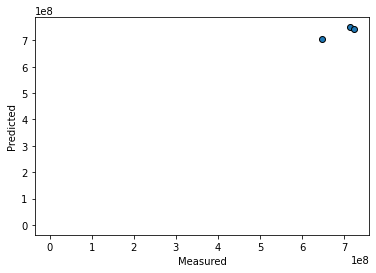

In [46]:
fig, ax = plt.subplots()
ax.scatter(inv_y_test, inv_y_pred, edgecolors=(0,0,0))
ax.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], 'k--')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

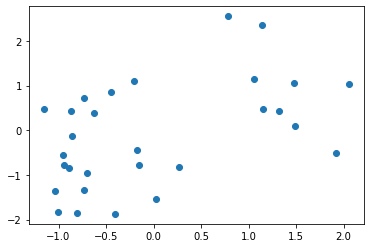

In [47]:
predictions = cross_val_predict(regressor_MultiLinear, X_train, y_train, cv=kfold)   
plt.scatter(y_train, predictions)

#### We can similarly predict GMV for every service. 

#### The predictors for GO-FOOD for 28-Jan look as follows - 



In [33]:
dfs_tr_food_sum[dfs_tr_food_sum.booking_dt == pd.to_datetime("2021-01-28").date()]

,booking_dt,actual_gmv,week,day,day_of_week,month,is_weekend_flag,dw_sin,dw_cos,mnth_sin,mnth_cos,dm_sin,dm_cos
28,2021-01-28,633067993.0,4,28,3,1,0,0.433884,-0.900969,0.0,1.0,-0.724793,0.688967
